In [24]:
# autoreloadを有効化
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt
import numpy as np

from qulacs import QuantumCircuit
from qulacs.gate import CNOT
from qulacsvis import circuit_drawer

from qc_ft_prob import fourier_series_coeffs, build_Uc_circuit_from_ck_cascade, build_c_tilde_amplitudes_from_ck, iqft_circuit

# 関数の設定

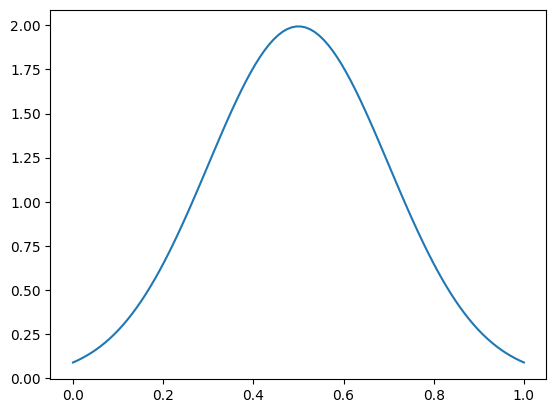

In [26]:
# ガウス関数
sigma = 0.2
mu = 0.5
func = lambda x: 1/np.sqrt(2*np.pi*sigma*sigma) * np.exp(-((x-mu)**2) / (2*sigma*sigma))

# フーリエ求数計算
# サンプリング範囲 = (0, 1)
x0 = 0
x1 = 1
# フーリエ求数は [+M,...,-M]の範囲
m = 2
M = 2**m - 1
# 全体のqubit数
n = 5

xs = np.linspace(x0, x1, 100)
ys = func(xs)
plt.plot(xs, ys)

Text(0, 0.5, 'c_k')

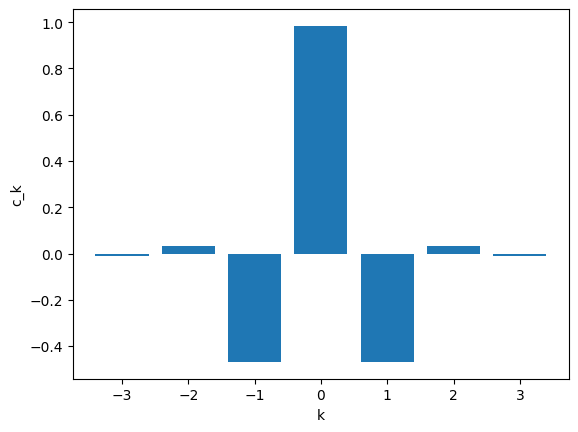

In [27]:
# フーリエ係数の決定
ks, cs, _ = fourier_series_coeffs(func, x0=x0, T=x1, M=M)
plt.bar(ks, cs.real)
plt.xlabel("k")
plt.ylabel("c_k")

Text(0, 0.5, 'c_k')

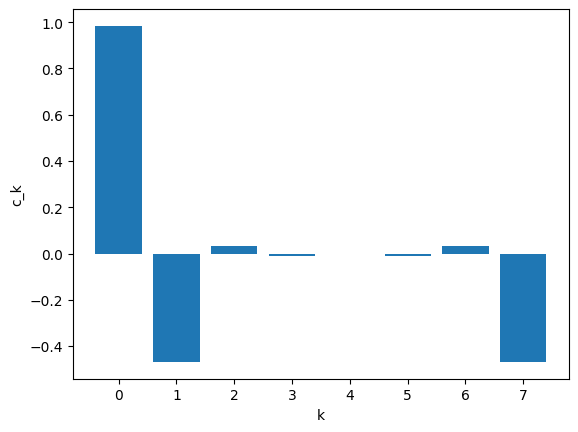

In [28]:
# 振幅への変換
amps, meta = build_c_tilde_amplitudes_from_ck(ks, cs, m=m)
plt.bar(range(len(amps)), amps.real)
plt.xlabel("k")
plt.ylabel("c_k")

<BarContainer object of 32 artists>

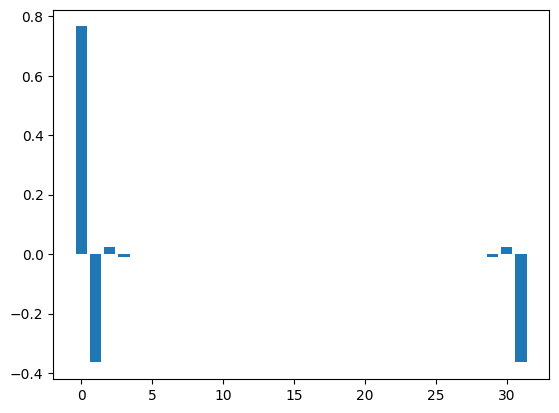

In [29]:
# Uc+CNOT
from qulacs import QuantumState
circ = QuantumCircuit(n)

# まず 0〜m の m+1 qubit に Uc を埋め込む
Uc_circuit, meta = build_Uc_circuit_from_ck_cascade(ks, cs)
circ.merge_circuit(Uc_circuit)  # qubit 番号はそのまま再利用される想定

# 次に CNOT を追加
control = m
for target in range(m+1, n):
    circ.add_gate(CNOT(control, target))

state = QuantumState(n)
state.set_zero_state()
circ.update_quantum_state(state)
psi = state.get_vector()

circuit_drawer(circ, "mpl")
plt.show()
plt.bar(range(len(psi)), psi.real)

<BarContainer object of 32 artists>

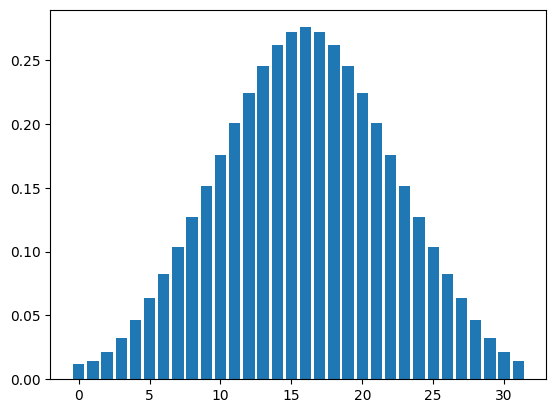

In [30]:
# iqft
circ = QuantumCircuit(n)

# まず 0〜m の m+1 qubit に Uc を埋め込む
circ.merge_circuit(Uc_circuit)  # qubit 番号はそのまま再利用される想定

# 次に CNOT を追加
control = m
for target in range(m+1, n):
    circ.add_gate(CNOT(control, target))

# IQFT
circ.merge_circuit(iqft_circuit(n))

state = QuantumState(n)
state.set_zero_state()
circ.update_quantum_state(state)
psi = state.get_vector()

circuit_drawer(circ, "mpl")
plt.show()
plt.bar(range(len(psi)), psi.real)

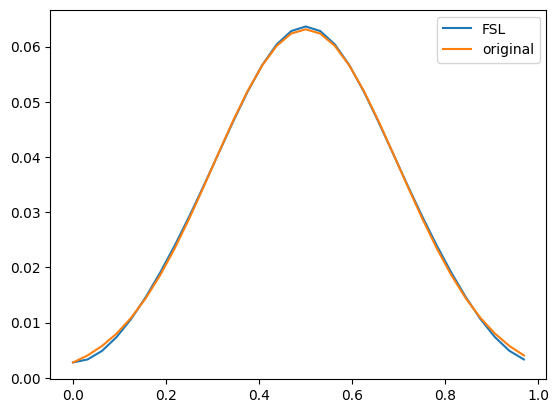

In [45]:
# 確認
xs = np.arange(len(psi)) / (2**n)
plt.plot(xs, psi.real / np.sum(psi.real), label="FSL")
plt.plot(xs, func(xs) / np.sum(func(xs)), label="original")
plt.legend()